## Import the necessary packages

In [1]:
import numpy as np 
import pandas as pd 
import os

import warnings
warnings.filterwarnings("ignore")

#importing libraries 
import re
from bs4 import BeautifulSoup
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
from nltk.corpus import stopwords


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


## Load the data 

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/personality-prediction/GFG/mbti_1.csv
/kaggle/input/personality-prediction/GFG/ForumMessages.csv


In [3]:
train=pd.read_csv('/kaggle/input/personality-prediction/GFG/mbti_1.csv')
forum=pd.read_csv('/kaggle/input/personality-prediction/GFG/ForumMessages.csv')

In [4]:
train.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
forum.head()

,Unnamed: 0,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal,MedalAwardDate
0,8427,784283,60581,4701687,03/24/2020 04:42:45,NaN,<p><strong>Think About The Data</strong></p>\n...,NaN,NaN
1,9564,784295,60581,4701687,03/24/2020 04:56:27,783670.0,<p>good point!</p>,NaN,NaN
2,9579,784298,60581,4701687,03/24/2020 05:02:18,781693.0,<p>Nice thoughts!</p>,NaN,NaN
3,13138,784405,60581,4662825,03/24/2020 07:34:31,NaN,<p>All fields that has year data maxes up on 2...,NaN,NaN
4,19987,787791,60581,3780256,03/27/2020 04:46:14,NaN,<p>The dataset reflects the real estate scenar...,NaN,NaN


## Preprocessing

In [6]:
train['posts']

0       'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1       'I'm finding the lack of me in these posts ver...
2       'Good one  _____   https://www.youtube.com/wat...
3       'Dear INTP,   I enjoyed our conversation the o...
4       'You're fired.|||That's another silly misconce...
                              ...                        
8670    'https://www.youtube.com/watch?v=t8edHB_h908||...
8671    'So...if this thread already exists someplace ...
8672    'So many questions when i do these things.  I ...
8673    'I am very conflicted right now when it comes ...
8674    'It has been too long since I have been on per...
Name: posts, Length: 8675, dtype: object

In [7]:
train['type'].unique()

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

In [8]:
mbti={'I':'Introversion','E':'Extroversion','N':'Intuition','S':'Sensing','T':'Thinking','F':'Feeling','J':'Judging','P':'Perceiving'}
mbti

{'I': 'Introversion',
 'E': 'Extroversion',
 'N': 'Intuition',
 'S': 'Sensing',
 'T': 'Thinking',
 'F': 'Feeling',
 'J': 'Judging',
 'P': 'Perceiving'}

In [9]:
#Now looking at the personality distrubution in the training data
type_count=train['type'].value_counts()
print(type_count)

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


Personality types start descending from the top to bottom

In [10]:
print("Missing values in test data: ")
train.isnull().sum()

Missing values in test data: 


type     0
posts    0
dtype: int64

In [11]:
print("Missing values in form data: ")
forum.isnull().sum()

Missing values in form data: 


Unnamed: 0                  0
Id                          0
ForumTopicId                0
PostUserId                  0
PostDate                    0
ReplyToForumMessageId    1040
Message                     4
Medal                    1735
MedalAwardDate           1731
dtype: int64

In [12]:
forum['Medal'].value_counts()

3.0    261
2.0     29
1.0     17
Name: Medal, dtype: int64

In [13]:
forum['Message']=forum['Message'].fillna('')
forum['Medal']=forum['Medal'].fillna(0)

print("Missing values in form data: ")
print(forum.isnull().sum())

Missing values in form data: 
Unnamed: 0                  0
Id                          0
ForumTopicId                0
PostUserId                  0
PostDate                    0
ReplyToForumMessageId    1040
Message                     0
Medal                       0
MedalAwardDate           1731
dtype: int64


#### Now, we will group the user by PostUserId since a particular user could have posted more than once.

In [14]:
forum_data = forum.groupby('PostUserId')['Message'].agg(lambda col: ' '.join(col)).reset_index()
forum_data['PostUserId'].value_counts()

9028       1
4746345    1
4771974    1
4770260    1
4767344    1
          ..
2902238    1
2900261    1
2894958    1
2891924    1
7152530    1
Name: PostUserId, Length: 1857, dtype: int64

In [15]:
train['posts'][10]

"'One time my parents were fighting over my dad's affair and my dad pushed my mom. The fall broke her finger.  She's pointed a gun at him and made him get on his knees and beg for his life. She's...|||I'm gonna talk about what a piece of shit my dad is now.  He's an alcoholic and he has some kind of serious mental problem when it comes to complying with the IRS. (In his words, Laws don't apply...|||OMG...at the women's center I lived at, run by a Catholic charity, the fat bully program manager took it upon herself to change policy so that tenants were FORCED to attend the Christmas party. If...|||I don't work, but I have a calling I am 100% committed to 24/7 with no vacation or off days EVER. I'm a Kundalini mystic.  Oh, I don't get paid, either!  It's one of those destined things...|||My art teacher in high school had a stack of art school catalogs. When I saw the one for the school I ended up going to, I immediately knew that was the one. Without any research. It was like when...|||I

## Text Cleaning

In [16]:
def text_cleaning(text):
    text=BeautifulSoup(text,'lxml').text
    #removing html and seperators
    text=re.sub(r'\|\|\|', r'  ', text)
    text=re.sub(r'http\S+', r'  ', text)
    ### Special character removal 
    #removing puntuations
    text=text.replace('.', '  ')
    translator=str.maketrans('', '', string.punctuation)
    text=text.translate(translator)
    #removing numbers
    text=''.join(i for i in text if not i.isdigit())
    return text

In [17]:
## Highlight the bold words - CAPS

def split_uppercase(text):
    text_list = text.split()
    new_list = []
    for i in text_list:
        if i.isupper() == False: 
            word = re.sub(r'([A-Z])', r' \1', i)
            new_list.append(word)
        else:
            word = i
            new_list.append(word)
    words = ' '.join(new_list)
    return words

In [18]:
def stem_text(text):
    stemmer = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()
    words_list = word_tokenize(text)
    new_list = []
    for i in words_list:
        word = stemmer.stem(i)
        word = lemmatizer.lemmatize(word)
        new_list.append(word)
        
    words = new_list
    words = ' '.join(words)
    return words

In [19]:
def Preprocessor(text):
    text1=text_cleaning(text)
    text2=split_uppercase(text1)
    text2 = stem_text(text2)
    return text2

## Vectorization 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

In [21]:
text = """
Bengaluru live news updates:
While CCTV visuals from the location, shared by police, 
showed the autorickshaw catching fire following what appeared to be a minor explosion, a police official, 
however, did not confirm if it was a ‘blast.’
"""
t = Preprocessor(text)
vect = tfidf.fit_transform(sent_tokenize(t))

#IDF for all words in the vocabulary
print("IDF for all words in the vocabulary",tfidf.idf_)
print("-"*10)
#All words in the vocabulary.
print("All words in the vocabulary",tfidf.get_feature_names())
print("-"*10)

#TFIDF representation for all documents in our corpus 
print("TFIDF representation for all documents in our corpus\n",vect.toarray()) 
print("-"*10)


test ='''
Bengaluru live news updates: Mangaluru blast an ‘act of terror’, state police & central agencies probing, says DGP
'''
T=text_cleaning(test)
T=split_uppercase(T)
T = stem_text(T)

temp = tfidf.transform(sent_tokenize(T))
print("Tfidf representation for text :",T,":\n", temp.toarray())

IDF for all words in the vocabulary [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
----------
All words in the vocabulary ['appear', 'autorickshaw', 'be', 'bengaluru', 'blast', 'by', 'catch', 'cctv', 'confirm', 'did', 'explos', 'fire', 'follow', 'from', 'howev', 'if', 'it', 'live', 'locat', 'minor', 'news', 'not', 'offici', 'polic', 'share', 'show', 'the', 'to', 'updat', 'visual', 'wa', 'what', 'while']
----------
TFIDF representation for all documents in our corpus
 [[0.16012815 0.16012815 0.16012815 0.16012815 0.16012815 0.16012815
  0.16012815 0.16012815 0.16012815 0.16012815 0.16012815 0.16012815
  0.16012815 0.16012815 0.16012815 0.16012815 0.16012815 0.16012815
  0.16012815 0.16012815 0.16012815 0.16012815 0.16012815 0.32025631
  0.16012815 0.16012815 0.32025631 0.16012815 0.16012815 0.16012815
  0.16012815 0.16012815 0.16012815]]
----------
Tfidf representation for text : bengaluru live news updat mangaluru blast an ‘ act of

## Create Pipeline

In [22]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scoring = {'acc': 'accuracy',
           'neg_log_loss': 'neg_log_loss',
           'f1_micro': 'f1_micro'}

### TFIDF

In [23]:
%%time
#countVect=CountVectorizer(ngram_range=(1,1), stop_words='english', lowercase=True, max_features=5000)
tfidf = TfidfVectorizer(ngram_range=(1,1), 
                        stop_words='english',
                        preprocessor=Preprocessor,
                        #tokenizer=None, 
                        lowercase=True, 
                        max_features=5000)

countVect=CountVectorizer(ngram_range=(1,1), 
                          stop_words='english',
                          preprocessor=Preprocessor,
                          lowercase=True, 
                          max_features=5000)


model = Pipeline(
    [
        ('Vectorize',tfidf),
        ('lr',LogisticRegression(class_weight='balanced',C=0.005))
    ])

results=cross_validate(model, train['posts'], train['type'], cv=kfolds, scoring=scoring, n_jobs=-1)

CPU times: user 231 ms, sys: 431 ms, total: 663 ms
Wall time: 11min 49s


### CountVectorizer

In [24]:
%%time
#countVect=CountVectorizer(ngram_range=(1,1), stop_words='english', lowercase=True, max_features=5000)
countVect = CountVectorizer(ngram_range=(1,1), 
                        stop_words='english',
                        preprocessor=Preprocessor,
                        #tokenizer=None, 
                        lowercase=True, 
                        max_features=5000)

model = Pipeline(
    [
        ('countvectorizer',countVect),
        ('lr',LogisticRegression(class_weight='balanced',C=0.005))
    ])

results=cross_validate(model, train['posts'], train['type'], cv=kfolds, scoring=scoring, n_jobs=-1)

CPU times: user 204 ms, sys: 391 ms, total: 595 ms
Wall time: 12min 2s


In [25]:
print("Accuracy: {:0.5f} ".format(np.mean(results['test_acc'])))
print("Logloss: {:0.5f} ".format(np.mean(-1*results['test_neg_log_loss'])))

Accuracy: 0.61602 
Logloss: 1.38048 


In [26]:
%%time
model.fit(train['posts'],train['type'])

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'el', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'le', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'plea', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/opt/conda/lib/python3.7/site-packages/bs4/__i

CPU times: user 4min 13s, sys: 34.4 s, total: 4min 47s
Wall time: 4min 8s


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=5000,
                                 preprocessor=<function Preprocessor at 0x7fc5c0a2fef0>,
                                 stop_words='english')),
                ('lr', LogisticRegression(C=0.005, class_weight='balanced'))])

## Model Predictions

In [27]:
pred=model.predict(forum_data['Message'])

In [28]:
count=np.unique(pred,return_counts=True)
list_of_preds=list(zip(count[0],count[1]))
pred_df=pd.DataFrame(list_of_preds, columns=['Personality','Count'])
pred_df

,Personality,Count
0,ENFJ,4
1,ENFP,3
2,ENTJ,24
3,ENTP,65
4,ESFJ,18
5,ESFP,330
6,ESTJ,10
7,ESTP,18
8,INFJ,2
9,INFP,8


## Observations: Plotting a Bar Graph

In [29]:
#importing the libraries
import matplotlib.pyplot as plt
import seaborn as sns

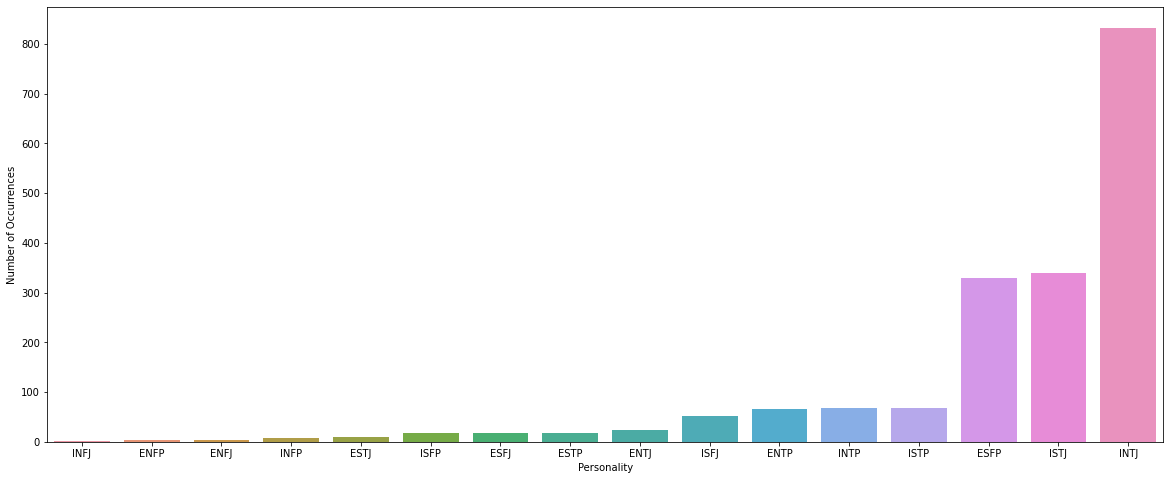

In [30]:
pred_df.sort_values('Count', inplace=True)
plt.figure(figsize=(20,8))
sns.barplot(x=pred_df['Personality'], y=pred_df['Count'])
plt.ylabel('Number of Occurrences')
plt.xlabel('Personality')
plt.show()

#### So from the above bar graph, we can conclude that most Kaggle users have *INTJ (Introversion Intuition Thinking Judging)* type of Personality.